# Exploratory Data Analysis on Employee Exit Surveys

Author: James Jordan
<br>
Project Date: 10/29/2020

## About

Data comes from two surveys from the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia.

Answers or goals for the data analysis is to determine the answer to the following two questions:

- Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?
- Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

#### Dataquest.io

Motivation and guidance for this project comes from the website [DataQuest.io](dataquest.io). This specific project falls under the Guided Project within the **Data Cleaning and Analysis** section.

### Importing Data

In [834]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

%matplotlib inline

dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')

We can quickly see we have a bit of work to do with these two datasets. There are many columns with mostly missing data, which could be due to an an undetected error the data, many columns with data not related to the our goals of the data analysis and missing data in the columns we do want to investigate.

In [835]:
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
ID                                     822 non-null int64
SeparationType                         822 non-null object
Cease Date                             822 non-null object
DETE Start Date                        822 non-null object
Role Start Date                        822 non-null object
Position                               817 non-null object
Classification                         455 non-null object
Region                                 822 non-null object
Business Unit                          126 non-null object
Employment Status                      817 non-null object
Career move to public sector           822 non-null bool
Career move to private sector          822 non-null bool
Interpersonal conflicts                822 non-null bool
Job dissatisfaction                    822 non-null bool
Dissatisfaction with the department    822 non-null bool
Physical work environ

In [836]:
tafe_survey.isnull().sum()

Record ID                                                                                                                                                          0
Institute                                                                                                                                                          0
WorkArea                                                                                                                                                           0
CESSATION YEAR                                                                                                                                                     7
Reason for ceasing employment                                                                                                                                      1
Contributing Factors. Career Move - Public Sector                                                                                                                265
Contributi

### Fixing import errors

Above it was noticed that the dete_survey dataframe contains 'Not Stated' values that indicate values are missing, but they aren't represented as NaN. So first off the dataset will be reimported correcting this problem.

And next, all of the columns that are not necessary for answer the two questions will be dropped.

In [837]:
# Reimporting dataset and assigning NA values correctly
dete_survey = pd.read_csv('dete_survey.csv', na_values=['Not Started'])

# Removing unnecessary columns
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

### Column Renaming

Many of the columns need renaming so that data can be compared and eventually merged between the two datasets. To do so the columns need to be named using the same naming convention.

In [838]:
# Updating dete column names
dete_survey_updated.columns = dete_survey_updated.columns.str.upper().str.replace(' ', '_').str.replace(r'\s+$', '')
dete_survey_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 35 columns):
ID                                     822 non-null int64
SEPARATIONTYPE                         822 non-null object
CEASE_DATE                             822 non-null object
DETE_START_DATE                        822 non-null object
ROLE_START_DATE                        822 non-null object
POSITION                               817 non-null object
CLASSIFICATION                         455 non-null object
REGION                                 822 non-null object
BUSINESS_UNIT                          126 non-null object
EMPLOYMENT_STATUS                      817 non-null object
CAREER_MOVE_TO_PUBLIC_SECTOR           822 non-null bool
CAREER_MOVE_TO_PRIVATE_SECTOR          822 non-null bool
INTERPERSONAL_CONFLICTS                822 non-null bool
JOB_DISSATISFACTION                    822 non-null bool
DISSATISFACTION_WITH_THE_DEPARTMENT    822 non-null bool
PHYSICAL_WORK_ENVIRON

In [839]:
# Updating tafe column names
tafe_column_dict = {'Record ID': 'id', 'CESSATION YEAR': 'cease_date', 'Reason for ceasing employment': 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age', 'Employment Type. Employment Type': 'employment_status', 'Classification. Classification': 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service', 'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
tafe_survey_updated = tafe_survey_updated.rename(tafe_column_dict, axis=1)

### Selecting Only Resignations

Below data only containing resignations is selected because this is what is asked by our two original data analysis questions.

This is done by using the pandas built in str function .contains() and a regex pattern to find all matches of resignations.

In [840]:
dete_survey_updated['SEPARATIONTYPE'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: SEPARATIONTYPE, dtype: int64

In [841]:
pattern = r'[Rr]esignation'
dete_bool = dete_survey_updated['SEPARATIONTYPE'].str.contains(pattern)
dete_survey_resignations = dete_survey_updated[dete_bool]
dete_survey_resignations['SEPARATIONTYPE'].value_counts()

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: SEPARATIONTYPE, dtype: int64

In [842]:
tafe_bool = tafe_survey_updated['separationtype'].str.contains(pattern, na=False)
tafe_survey_resignations = tafe_survey_updated[tafe_bool]
tafe_survey_resignations['separationtype'].value_counts()

Resignation    340
Name: separationtype, dtype: int64

In [843]:
dete_survey_resignations['CEASE_DATE'].value_counts()

2012          126
2013           74
01/2014        22
12/2013        17
06/2013        14
09/2013        11
Not Stated     11
07/2013         9
11/2013         9
10/2013         6
08/2013         4
05/2012         2
05/2013         2
2010            1
09/2010         1
07/2012         1
07/2006         1
Name: CEASE_DATE, dtype: int64

#### Fixing Dates

Here the date columns are made into float values and dates that are missing are removed from the associated datasets.

In [844]:
# Remove rows with year not available
dete_survey_resignations = dete_survey_resignations[~dete_survey_resignations['CEASE_DATE'].str.contains('Not Stated')]

In [845]:
print(dete_survey_resignations['CEASE_DATE'].head(10))
#dete_survey_resignations['CEASE_DATE'] = 
dete_survey_resignations['CEASE_DATE'] = dete_survey_resignations['CEASE_DATE'].str.replace(r'[0-9]{2}\/', '').astype(float)
dete_survey_resignations['CEASE_DATE'].head(10)

3     05/2012
5     05/2012
8     07/2012
9        2012
11       2012
12       2012
14       2012
16       2012
20       2012
21       2012
Name: CEASE_DATE, dtype: object


3     2012.0
5     2012.0
8     2012.0
9     2012.0
11    2012.0
12    2012.0
14    2012.0
16    2012.0
20    2012.0
21    2012.0
Name: CEASE_DATE, dtype: float64

In [846]:
dete_survey_resignations['CEASE_DATE'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: CEASE_DATE, dtype: int64

In [847]:
tafe_survey_resignations['cease_date'].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

In [848]:
start_date_bool = dete_survey_resignations['DETE_START_DATE'].str.contains('Not Stated', na=False)
dete_survey_resignations = dete_survey_resignations[~start_date_bool]
dete_survey_resignations['DETE_START_DATE'] = dete_survey_resignations['DETE_START_DATE'].astype(float)

### Calculating Service Time

In the DETE dataset there is no column for the amount of time a person worked for. So this is calulated using the simple formula: 

service_time = cease_date - start_date

In [849]:
dete_survey_resignations['INSTITUTE_SERVICE'] = dete_survey_resignations['CEASE_DATE'] - dete_survey_resignations['DETE_START_DATE']
dete_survey_resignations['INSTITUTE_SERVICE'].describe()

count    273.000000
mean      10.457875
std        9.931709
min        0.000000
25%        3.000000
50%        7.000000
75%       16.000000
max       49.000000
Name: INSTITUTE_SERVICE, dtype: float64

### Consoildating Dissatified Employees

Here the various dissatisfied employees are consolidated into its own column for analysis. Because there are several reasons for dissatisfaction, they were originally imported into different columns. However, we just want to look at the overall numbers of dissatisfied employees.

Below are the columns we'll use to categorize employees as "dissatisfied" from each dataframe:

    1. tafe_survey_updated:
        - Contributing Factors. Dissatisfaction
        - Contributing Factors. Job Dissatisfaction
    2. dafe_survey_updated:
        - job_dissatisfaction
        - dissatisfaction_with_the_department
        - physical_work_environment
        - lack_of_recognition
        - lack_of_job_security
        - work_location
        - employment_conditions
        - work_life_balance
        - workload

If the employee indicated any of the factors above caused them to resign, we'll mark them as dissatisfied in a new column. After our changes, the new dissatisfied column will contain just the following values:

    - True: indicates a person resigned because they were dissatisfied in some way
    - False: indicates a person resigned because of a reason other than dissatisfaction with the job
    - NaN: indicates the value is missing


In [850]:
tafe_survey_resignations['Contributing Factors. Dissatisfaction'].value_counts(dropna = False)

-                                         277
Contributing Factors. Dissatisfaction      55
NaN                                         8
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [851]:
# Converts dissatisfaction values to either True, False or NaN
def update_val(val):
    if pd.isnull(val):
        return np.nan
    elif val == '-':
        return False
    else:
        return True

In [852]:
tafe_survey_resignations['dissatisfied'] = tafe_survey_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_val).any(1, skipna=False)
tafe_survey_resignations['dissatisfied'].value_counts(dropna=False)


False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [853]:
dete_survey_resignations['dissatisfied'] = dete_survey_resignations[['JOB_DISSATISFACTION', 'DISSATISFACTION_WITH_THE_DEPARTMENT', 'PHYSICAL_WORK_ENVIRONMENT', 'LACK_OF_RECOGNITION', 'LACK_OF_JOB_SECURITY', 'WORK_LOCATION', 'EMPLOYMENT_CONDITIONS', 'WORK_LIFE_BALANCE', 'WORKLOAD']].any(1, skipna=False)
dete_survey_resignations['dissatisfied'].value_counts(dropna=False)


True     137
False    136
Name: dissatisfied, dtype: int64

In [854]:
tafe_resignations_up = tafe_survey_resignations.copy()
dete_resignations_up = dete_survey_resignations.copy()

### Combining The Data

Below, we'll add an institute column so that we can differentiate the data from each survey after we combine them. Then, we'll combine the dataframes and drop any remaining columns we don't need.

In [855]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

In [856]:
dete_resignations_up.columns = dete_resignations_up.columns.str.lower()

In [857]:
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)
combined.notnull().sum().sort_values(ascending=False)

institute                                              613
separationtype                                         613
id                                                     613
cease_date                                             608
dissatisfied                                           605
institute_service                                      563
employment_status                                      563
age                                                    561
position                                               560
gender                                                 558
Institute                                              340
WorkArea                                               340
Contributing Factors. Interpersonal Conflict           332
Contributing Factors. Job Dissatisfaction              332
Contributing Factors. Maternity/Family                 332
Contributing Factors. NONE                             332
Contributing Factors. Ill Health                       3

In [858]:
# Drop columns with less than 500 non null values
combined_updated = combined.dropna(thresh = 500, axis =1).copy()

### Clean the Service Column

Next, we'll clean the institute_service column and categorize employees according to the following definitions:

- New: Less than 3 years in the workplace
- Experienced: 3-6 years in the workplace
- Established: 7-10 years in the workplace
- Veteran: 11 or more years in the workplace

Our analysis is based on this [article](https://www.businesswire.com/news/home/20171108006002/en/Age-Number-Engage-Employees-Career-Stage), which makes the argument that understanding employee's needs according to career stage instead of age is more effective.

In [859]:
# Check the unique values
combined_updated['institute_service'].value_counts(dropna=False)

Less than 1 year      73
1-2                   64
3-4                   63
NaN                   50
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
0.0                   20
3.0                   20
6.0                   17
4.0                   16
2.0                   14
9.0                   14
7.0                   13
More than 20 years    10
8.0                    8
13.0                   8
15.0                   7
20.0                   7
10.0                   6
12.0                   6
14.0                   6
22.0                   6
17.0                   6
18.0                   5
16.0                   5
11.0                   4
23.0                   4
24.0                   4
19.0                   3
32.0                   3
21.0                   3
39.0                   3
30.0                   2
25.0                   2
26.0                   2
28.0                   2
36.0                   2


In [860]:
# Extract the years of service and convert the type to float
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)')
combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')

# Check the years extracted are correct
combined_updated['institute_service_up'].value_counts()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



1.0     159
3.0      83
5.0      56
7.0      34
11.0     30
0.0      20
20.0     17
6.0      17
4.0      16
9.0      14
2.0      14
13.0      8
8.0       8
15.0      7
17.0      6
10.0      6
12.0      6
14.0      6
22.0      6
16.0      5
18.0      5
24.0      4
23.0      4
39.0      3
19.0      3
21.0      3
32.0      3
28.0      2
36.0      2
25.0      2
30.0      2
26.0      2
29.0      1
38.0      1
42.0      1
27.0      1
41.0      1
35.0      1
49.0      1
34.0      1
33.0      1
31.0      1
Name: institute_service_up, dtype: int64

In [861]:
# Convert years of service to categories
def transform_service(val):
    if val >= 11:
        return "Veteran"
    elif 7 <= val < 11:
        return "Established"
    elif 3 <= val < 7:
        return "Experienced"
    elif pd.isnull(val):
        return np.nan
    else:
        return "New"
combined_updated['service_cat'] = combined_updated['institute_service_up'].apply(transform_service)

In [862]:
# Quick check of the update
combined_updated['service_cat'].value_counts()

New            193
Experienced    172
Veteran        136
Established     62
Name: service_cat, dtype: int64

### Initial Analysis

Finally, we'll replace the missing values in the dissatisfied column with the most frequent value, False. Then, we'll calculate the percentage of employees who resigned due to dissatisfaction in each service_cat group and plot the results.

Note that since we still have additional missing values left to deal with, this is meant to be an initial introduction to the analysis, not the final analysis.

In [863]:
# Verify the unique values
combined_updated['dissatisfied'].value_counts(dropna=False)

False    377
True     228
NaN        8
Name: dissatisfied, dtype: int64

In [864]:
# Replace missing values with the most frequent value, False
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(False)

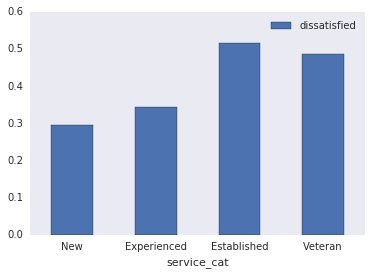

In [865]:
# Calculate the percentage of employees who resigned due to dissatisfaction in each category
dis_pct = combined_updated.pivot_table(index='service_cat', values='dissatisfied')

# Organizing the plot from newest to oldest employees
dis_pct['sorting'] = [3, 2, 1, 4]
dis_pct = dis_pct.sort_values('sorting')
dis_pct = dis_pct.drop(['sorting'], axis=1)

# Plot the results
dis_pct.plot(kind='bar', rot=0)

### Conclusion

From the initial analysis above, we can tentatively conclude that employees with 7 or more years of service are more likely to resign due to some kind of dissatisfaction with the job than employees with less than 7 years of service. However, we need to handle the rest of the missing data to finalize our analysis.